In [68]:
%load_ext autoreload
%autoreload 2

from collect_experiments import display_experiments, display_experiments_helper, BLISSExperiment
from utils import get_eval_stats, analyze_protein_gen_helper_violin
import seaborn as sn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def display_full_comparison(align_param, N, target_protein, summary_func, save_figs=False):
    param_descr = {'ddg' : 'ΔΔG',
                        'll' : 'Log Likelihood',
                        'scrmsd' : 'scRMSD',
                        'success_rate' : 'Success Rate'}
    summary_func_descr = {np.median : 'Median',
                        np.mean : 'Average'}
    
    # Assume get_eval_stats is defined elsewhere
    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"
    pretrained_n10_path = base_dir + "pretrained_test.csv"
    bon_n10_path = base_dir + f"pretrained_test_{align_param}_bon_N={N}_specfeedback=0.csv"
    beam_n10_path = base_dir + f"pretrained_test_{align_param}_beam_N={N}_specfeedback=0_W=1_stepsperlevel=1.csv"
    pretrained_spectral_n10_path = base_dir + f"pretrained_test_{align_param}_bon_N=1_specfeedback=5.csv"
    bon_spectral_n10_path = base_dir + f"pretrained_test_{align_param}_bon_N={N}_specfeedback=5.csv"
    beam_spectral_n10_path = base_dir + f"pretrained_test_{align_param}_beam_N={N}_specfeedback=5_W=1_stepsperlevel=1.csv"

    drakes_n10_path = base_dir + "drakes_test.csv"
    drakes_spectral_n10_path = base_dir + f"drakes_test_{align_param}_bon_N=1_specfeedback=5.csv"
    drakes_bon_n10_path = base_dir + f"drakes_test_{align_param}_bon_N={N}_specfeedback=0.csv"
    drakes_beam_n10_path = base_dir + f"drakes_test_{align_param}_beam_N={N}_specfeedback=0_W=1_stepsperlevel=1.csv"
    drakes_bon_spectral_n10_path = base_dir + f"drakes_test_{align_param}_bon_N={N}_specfeedback=5.csv"
    drakes_beam_spectral_n10_path = base_dir + f"drakes_test_{align_param}_beam_N={N}_specfeedback=5_W=1_stepsperlevel=1.csv"

    datasets = {
        "Pretrain": {"before": pretrained_n10_path, "after": pretrained_spectral_n10_path},
        "Pretrain-BoN": {"before": bon_n10_path, "after": bon_spectral_n10_path},
        "Pretrain-Beam": {"before": beam_n10_path, "after": beam_spectral_n10_path},
        "DRAKES": {"before": drakes_n10_path, "after": drakes_spectral_n10_path},
        "DRAKES-BoN": {"before": drakes_bon_n10_path, "after": drakes_bon_spectral_n10_path},
        "DRAKES-Beam": {"before": drakes_beam_n10_path, "after": drakes_beam_spectral_n10_path}
    }

    base_out_path = f"/home/shai/BLISS_Experiments/DRAKES/figures/N{N}"

    dataset_descr = 'test' if target_protein is None else target_protein.lower()

    for eval_param in param_descr:
        before_stats, after_stats = [], []
        for name, paths in datasets.items():
            df_before = pd.read_csv(paths["before"])
            df_after  = pd.read_csv(paths["after"])
            before_stats.append(get_eval_stats(df_before, target_protein=target_protein, summary_func=summary_func)[eval_param])
            after_stats.append(get_eval_stats(df_after, target_protein=target_protein, summary_func=summary_func)[eval_param])

        categories = list(datasets.keys())
        x = np.arange(len(categories))
        width = 0.35

        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(9,6))

        # Bars for non-baseline methods
        bars_before = ax.bar(x - width/2, before_stats, width, label="Original", color="#4C78A8", alpha=0.9)
        bars_after  = ax.bar(x + width/2, after_stats, width, label="Spectral (K=5)", color="#72B7B2", alpha=0.9)

        # Add values inside the bars (white text)
        for bar_before, bar_after in zip(bars_before, bars_after):
            height_before = bar_before.get_height()
            height_after = bar_after.get_height()
            # Original
            ax.text(bar_before.get_x() + bar_before.get_width()/2, height_before/2,
                    f"{height_before:.2f}", ha="center", va="center", fontsize=9, color="white", weight="bold")
            # After
            ax.text(bar_after.get_x() + bar_after.get_width()/2, height_after/2,
                    f"{height_after:.2f}", ha="center", va="center", fontsize=9, color="white", weight="bold")
            # Improvement label above 'after' bar
            diff = height_after - height_before
            sign_symbol = "+" if diff >= 0 else "-"
            diff = abs(diff)
            ax.text(bar_after.get_x() + bar_after.get_width()/2, height_after + 0.03*max(after_stats),
                    f"{sign_symbol} {diff:.2f}", ha="center", va="bottom", fontsize=10, weight="bold", color="#333")

        if target_protein is not None:
            protein_descr = target_protein + " "
        else:
            protein_descr = ""

        if eval_param != 'success_rate': func_txt = f'{summary_func_descr[summary_func]} '
        else: func_txt = ''

        ax.set_ylabel(f"{func_txt}{param_descr[eval_param]}", fontsize=12, weight='bold')
        ax.set_xlabel(f"Alignment Method (N={N})", fontsize=12, weight='bold')
        ax.set_title(f"Spectral Enhanced {protein_descr}{param_descr[align_param]} Alignment", fontsize=15, weight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=11)
        ax.legend(frameon=True, fontsize=11, loc="upper left")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        plt.tight_layout()
        if save_figs:
            out_path = f'{base_out_path}/{dataset_descr}_n{N}_{align_param}_align_{eval_param}_eval.png'
            plt.savefig(out_path)
        plt.show()

    data = [pd.read_csv(datasets[x][y]) for x in datasets for y in ['before', 'after']]
    labels = [x + y for x in datasets for y in ['', '-Spectral']]
    colors = sn.color_palette("Set2", len(data))
    protein_output = target_protein + " " if target_protein is not None else ""

    ddg_outpath = f'{base_out_path}/{dataset_descr}_n{N}_ddg_eval_distribution.png' if save_figs else None
    ll_outpath = f'{base_out_path}/{dataset_descr}_n{N}_ll_eval_distribution.png' if save_figs else None
    scrmsd_outpath = f'{base_out_path}/{dataset_descr}_n{N}_scrmsd_eval_distribution.png' if save_figs else None
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'ddg_eval', y_label='Predicted ΔΔG', legend_pos='right', title=f'Sampling vs DRAKES Alignment {protein_output}ΔΔG Evaluation (N={N}, K=5)', out_path=ddg_outpath)
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'loglikelihood', y_label='Log Likelihood', legend_pos='right', title=f'Sampling vs DRAKES Alignment {protein_output}Log Likelihood Evaluation (N={N}, K=5)', out_path=ll_outpath)
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'scrmsd', y_label='scRMSD', legend_pos='right', title=f'Sampling vs DRAKES Alignment {protein_output}scRMSD Evaluation (N={N}, K=5)', out_path=scrmsd_outpath)

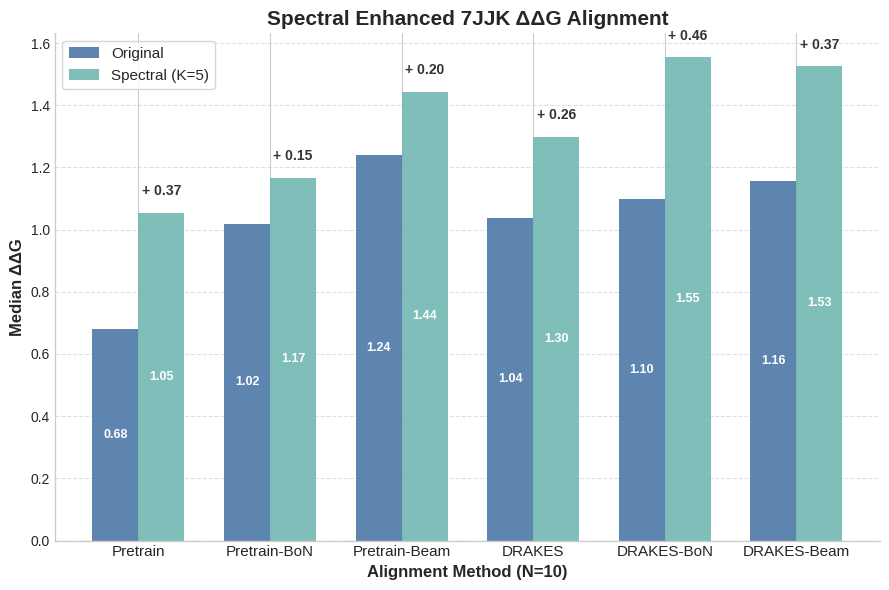

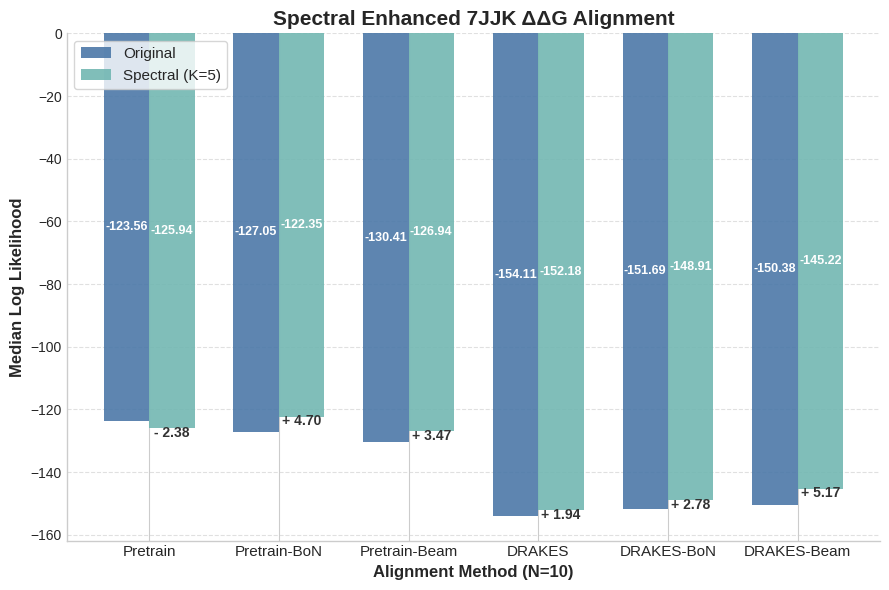

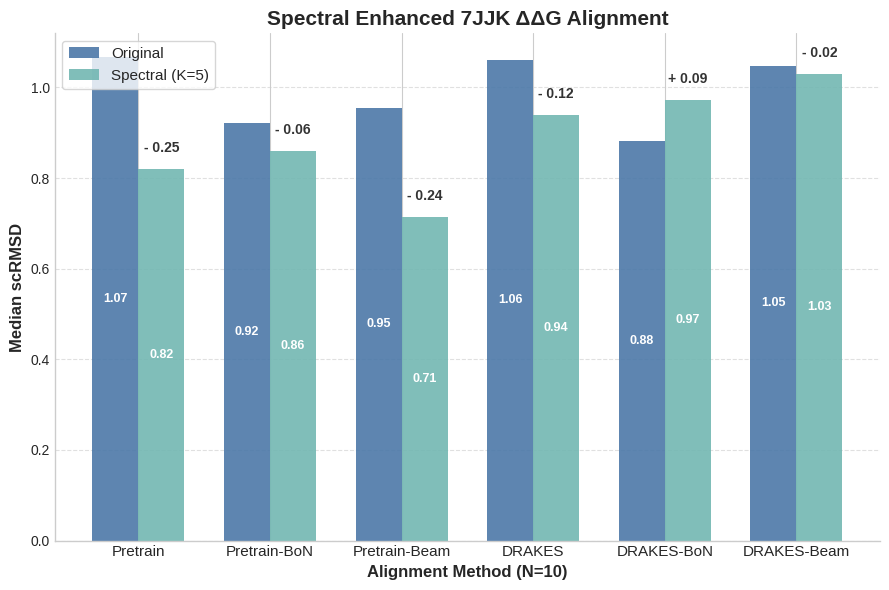

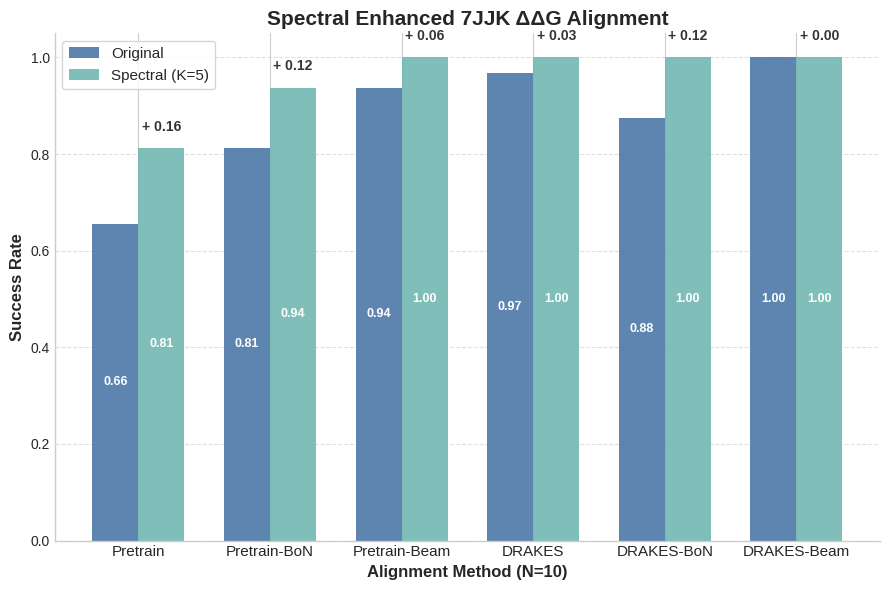

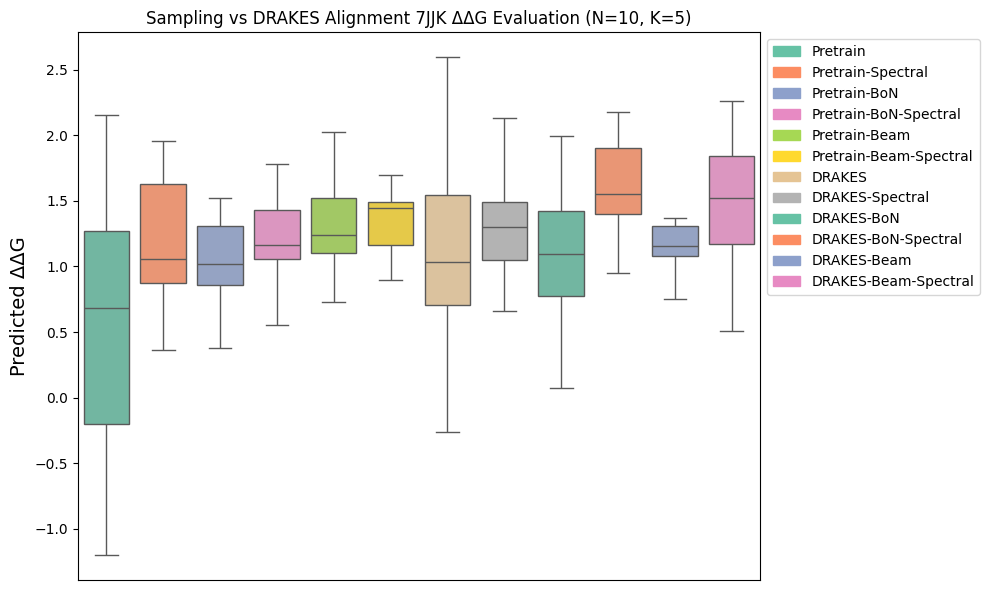

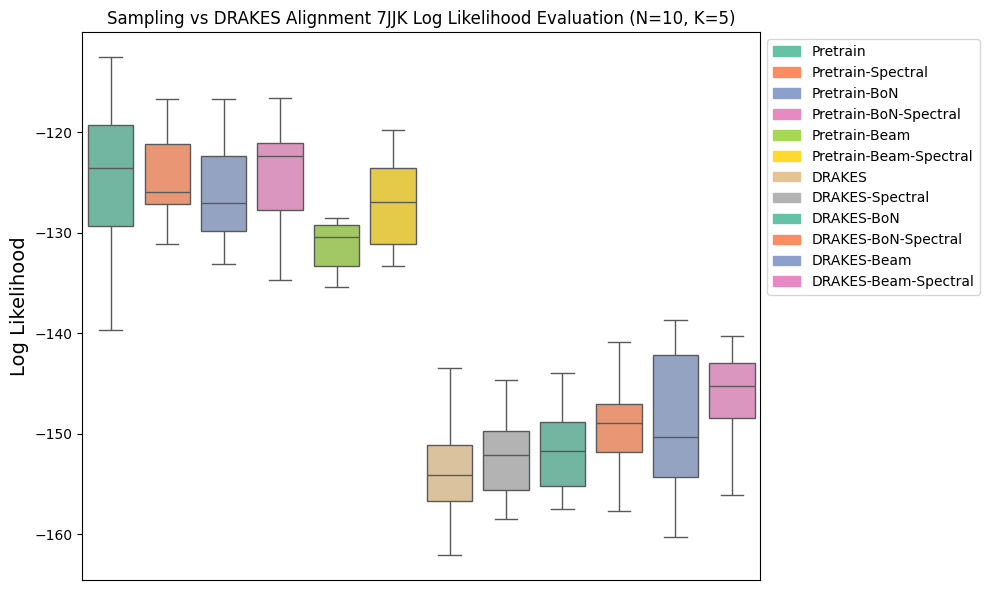

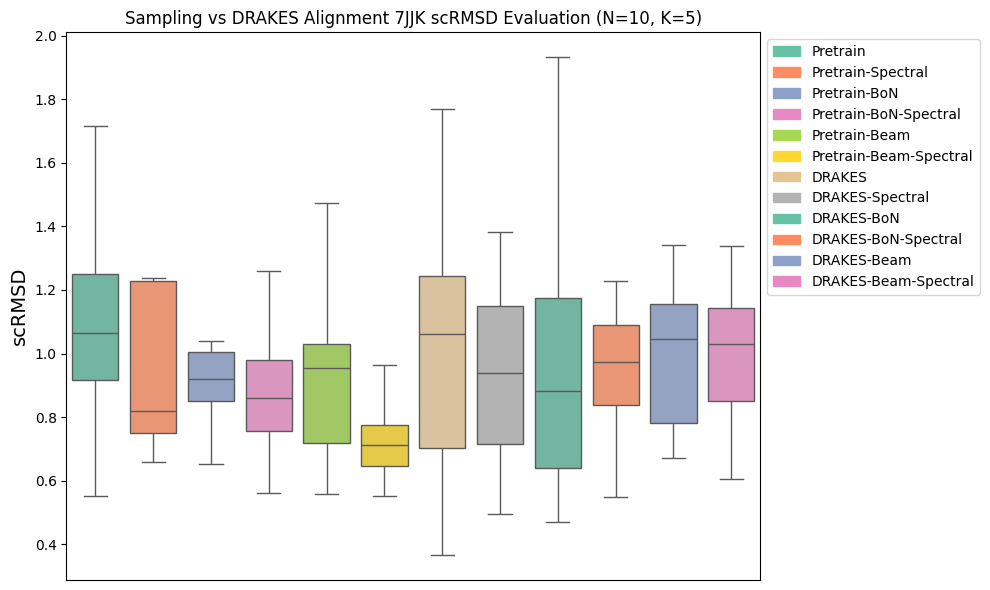

In [80]:
align_param = 'ddg'
N=10
target_protein = '7JJK'
summary_func = np.median

display_full_comparison(align_param, N, target_protein, summary_func, save_figs=False)

In [ ]:
display_experiments(dataset='test')

In [5]:
from matplotlib import pyplot as plt
import random 
import numpy as np

def evaluate_ddg_ll_corr_mult(df_list, labels, protein, title='', selected_samples=None):
    for i, df in enumerate(df_list):
        df = df[df['protein_name'] == protein + ".pdb"]
        pre_ddg = df['ddg_eval']
        pre_protgpt = df['loglikelihood']
        if selected_samples is not None and len(pre_ddg) > selected_samples: # type: ignore
            ids = random.sample(range(len(pre_ddg)), selected_samples) # type: ignore
            pre_ddg = np.array(pre_ddg)[ids]
            pre_protgpt = np.array(pre_protgpt)[ids]
        plt.scatter(pre_ddg, pre_protgpt, label=labels[i])
    plt.xlabel('ΔΔG')
    plt.ylabel('Log Likelihood')
    plt.title(title)
    plt.legend()
    plt.show()

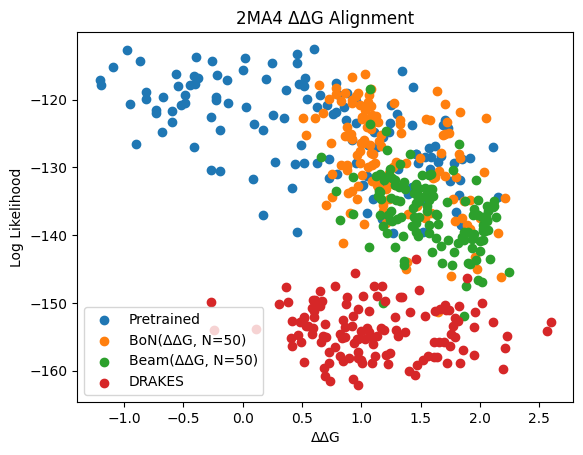

In [ ]:
exps = []
bliss_dir = '/home/shai/BLISS_Experiments/DRAKES/'
exp_dir = 'DRAKES/drakes_protein/fmif/eval_results/'
base_path = bliss_dir + exp_dir + 'test' + '/'

exps.append(BLISSExperiment(
    name='Pretrained',
    base_path=base_path,
    model='pretrained',
    dataset='test'))

exps.append(BLISSExperiment(
    name='BoN(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='bon',
    align_n=50))

exps.append(BLISSExperiment(
    name='Beam(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='beam',
    align_n=50,
    beam_w=1))

exps.append(BLISSExperiment(
    name='DRAKES',
    base_path=base_path,
    model='drakes',
    dataset='test'))

dfs = [e.get_df() for e in exps]
labels = [e.name for e in exps]

evaluate_ddg_ll_corr_mult(dfs, labels, '7JJK', selected_samples=None, title='2MA4 ΔΔG Alignment')